# Receiving the .keras file of the fine-tuned model.

In [1]:
# Import requirements
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.15.0'

In [2]:
# Creating train-, testdatasets
import tensorflow_datasets as tfds

(train_data, validation_data, test_data), ds_info = tfds.load(
    "oxford_flowers102",
    split=["train", "validation", "test"],
    shuffle_files=True,
    as_supervised=True, # data gets returned in tuple format
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7R7IS5/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7R7IS5/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7R7IS5/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
import json
with open("class_names.json", "w") as f:
  json.dump(ds_info.features["label"].names, f)


In [4]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

class_names = ds_info.features['label'].names

for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Flowers102 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (500, 667, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Flowers102 (tensor form): 72
  Class name (str form): water lily
        


In [5]:
# Preprocessing imgs
def preprocess_img(img, label, target_img_shape=384):
    """
    Converts img dtype from uint8 -> float32 and reshapes img to
    (target_img_shape, target_img_shape, 3)
    """
    img = tf.image.resize(img, size=(target_img_shape, target_img_shape))
    return tf.cast(img, tf.float32), label # return (float_32_img, label) tuple

In [6]:
# .prefetch(tf.data.AUTOTUNE)

# Map preprocessing function to training
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

validation_data = validation_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

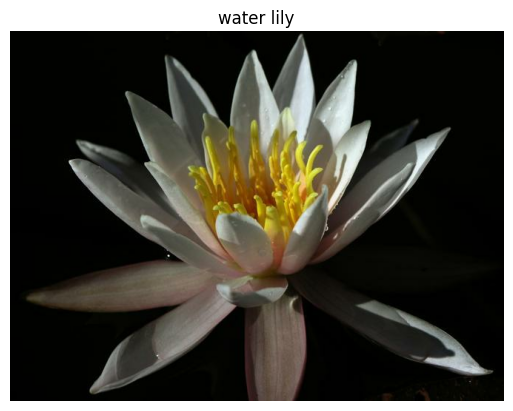

In [7]:
# Show the image
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [8]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [9]:
# Create a model
IMG_SHAPE = (384, 384)

# Create a base model
base_model = tf.keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable = False

# Create functiional model
inputs = keras.layers.Input(IMG_SHAPE + (3,))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(102,)(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

82420632/82420632 [==============================] - 5s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
 activation (Activation)     (None, 102)               0         
                                                                 
Total params: 20462022 (78.06 MB)
Trainable params: 130662 (5

In [11]:
# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [12]:
# Fit the model
history = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.15*len(validation_data))
)

Epoch 1/5
32/32 [==============================] - 39s 458ms/step - loss: 4.1720 - accuracy: 0.1569 - val_loss: 3.4271 - val_accuracy: 0.5000
Epoch 2/5
32/32 [==============================] - 10s 216ms/step - loss: 2.8366 - accuracy: 0.6529 - val_loss: 2.5603 - val_accuracy: 0.6719
Epoch 3/5
32/32 [==============================] - 9s 201ms/step - loss: 1.9956 - accuracy: 0.8363 - val_loss: 1.9733 - val_accuracy: 0.8203
Epoch 4/5
32/32 [==============================] - 10s 219ms/step - loss: 1.4512 - accuracy: 0.9039 - val_loss: 1.6098 - val_accuracy: 0.8438
Epoch 5/5
32/32 [==============================] - 9s 205ms/step - loss: 1.1002 - accuracy: 0.9275 - val_loss: 1.3898 - val_accuracy: 0.8438


In [13]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-25 15:01:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-25 15:01:20 (96.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [14]:
from helper_functions import plot_loss_curves

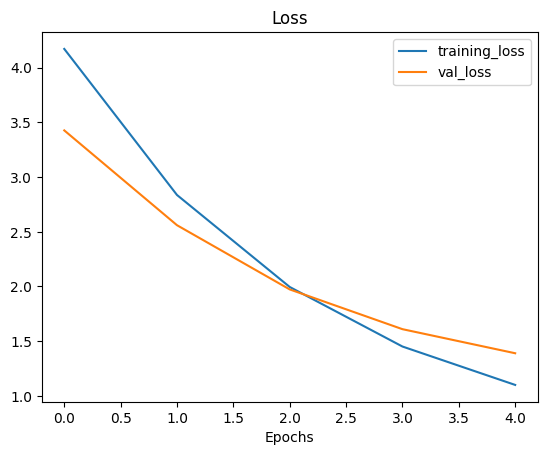

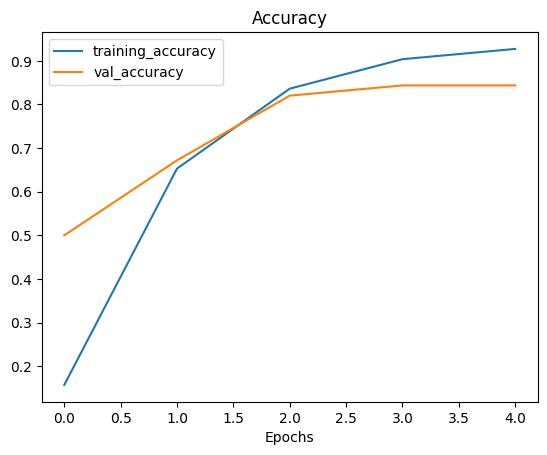

In [15]:
plot_loss_curves(history)

In [16]:
# Set all of the layers .trainable variable to True (so they're unfrozen)
model.trainable = True

In [17]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
filepath = "keras.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    mode="max",
    save_weights_only=True,
    save_best_only=True
)

In [19]:
# Start to fine-tune (all layers)
history_fine_tune = model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.15*len(validation_data)),
    initial_epoch=history.epoch[-1],
    callbacks=[model_checkpoint]
)

Epoch 5/10
32/32 [==============================] - 212s 2s/step - loss: 0.4220 - accuracy: 0.9255 - val_loss: 0.4989 - val_accuracy: 0.8984
Epoch 6/10
32/32 [==============================] - 24s 639ms/step - loss: 0.0542 - accuracy: 0.9931 - val_loss: 0.3851 - val_accuracy: 0.9062
Epoch 7/10
32/32 [==============================] - 27s 627ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.3212 - val_accuracy: 0.9141
Epoch 8/10
32/32 [==============================] - 23s 609ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.2982 - val_accuracy: 0.9297
Epoch 9/10
32/32 [==============================] - 22s 611ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2898 - val_accuracy: 0.9297
Epoch 10/10
32/32 [==============================] - 22s 606ms/step - loss: 5.0930e-04 - accuracy: 1.0000 - val_loss: 0.2979 - val_accuracy: 0.9219


In [22]:
# Get best weighs and biases & Evaluate the model
model.load_weights(filepath)
results = model.evaluate(test_data)
print(f"""Model val_loss: {results[0]}\nModel val_acc: {results[1]}""")

193/193 [==============================] - 32s 166ms/step - loss: 0.6861 - accuracy: 0.8231
Model val_loss: 0.6861376762390137
Model val_acc: 0.8230606317520142


In [23]:
# Save the model to import and use it later..
model.save("EfficientNetV2S_fine_tuned")

In [24]:
!zip -r /content/file.zip /content/EfficientNetV2S_fine_tuned

  adding: content/EfficientNetV2S_fine_tuned/ (stored 0%)
  adding: content/EfficientNetV2S_fine_tuned/keras_metadata.pb (deflated 97%)
  adding: content/EfficientNetV2S_fine_tuned/assets/ (stored 0%)
  adding: content/EfficientNetV2S_fine_tuned/saved_model.pb (deflated 92%)
  adding: content/EfficientNetV2S_fine_tuned/variables/ (stored 0%)
  adding: content/EfficientNetV2S_fine_tuned/variables/variables.index (deflated 78%)
  adding: content/EfficientNetV2S_fine_tuned/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/EfficientNetV2S_fine_tuned/fingerprint.pb (stored 0%)


In [27]:
!python -V

Python 3.10.12
